# Importando classes

In [1]:
# Torch
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, Subset

# CV2
import cv2

# Avaliação de resultados
from sklearn.metrics import accuracy_score

# Rodando scripts modularizados
%run "../pyScripts/devFunctions.py"

# PIL
from PIL import Image

# Numpy
import numpy as np

# Matplot
import matplotlib.pyplot as plt

# Definições

In [2]:
batch_size = 64
train_data = "../../../GeneralData/train"
test_data = "../../../GeneralData/test"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Transform

## Definindo as funções CV2
Essas funções são as responsáveis por alguns filtros específicos que serão aplicados nas imagens, a fim de melhorar o aprendizado.

In [3]:
# Função lambda que aplica o filtro Sobel
sobel_transform = transforms.Lambda(
    lambda img: Image.fromarray(
        cv2.convertScaleAbs(
            np.hypot(
                cv2.Sobel(np.array(img), cv2.CV_64F, 1, 0, ksize=3),
                cv2.Sobel(np.array(img), cv2.CV_64F, 0, 1, ksize=3)
            )
        )
    )
)


In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    sobel_transform,
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)), # Normalizando imagem para apenas um canal ao invés de 3 -> (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
])

In [5]:
train_set = datasets.ImageFolder(root=train_data, transform=transform)
test_set = datasets.ImageFolder(root=test_data, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

### Mostrando as imagens do trainset

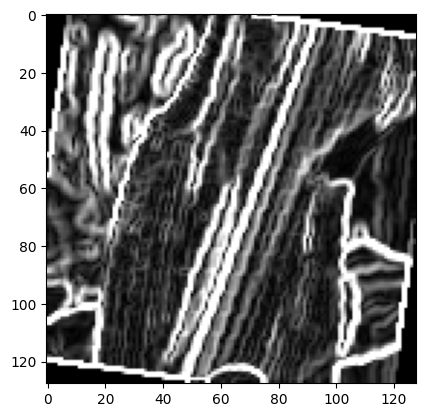

In [14]:
image = Image.open(train_set.imgs[3][0])
image_tensor = transform(image)

imshow(torchvision.utils.make_grid(image_tensor.unsqueeze(0)))

### Debug do Sobel

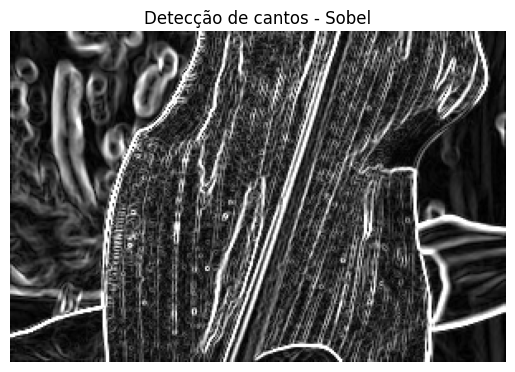

In [19]:
image = Image.open(train_set.imgs[3][0]).convert("L")
sobel_image = sobel_transform(image)

plt.imshow(sobel_image, cmap="gray")
plt.title("Detecção de cantos - Sobel")
plt.axis("off")
plt.show()


# Criando as classes

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Construção das hidden layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 128
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 30
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2) # 15
        # self.adaptative_pool = nn.AdaptiveAvgPool2d(7) <- Talvez Aplicar futuramente

        # Flatten
        self.fc1 = nn.Linear(128 * 15 * 15, 120)
        self.bn4 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

        # Ativação GeLU
        self.gelu = nn.GELU()
    
    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool(F.gelu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1)

        x = F.gelu(self.bn4(self.fc1(x)))
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)

        return x


# Definindo o otimizador e a função de perda

In [12]:
Net = NeuralNetwork().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)

# Treinando o modelo

In [13]:
for epoch in range(2):

    running_loss = 0.0

    for images, labels in train_loader:

        """
            Nesse caso, images é a representação em matriz da imagem.
            E labels é a representação de cada camada da CNN, se ela ativou ou não.
        """

        # Adquirindo entradas, "data" é uma lista [inputs, labels]
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # zerando os parâmetros dos gradientes
        optimizer.zero_grad()

        outputs = Net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')

print("Treinamento concluído!")

[1] loss: 0.098
[2] loss: 0.048
Treinamento concluído!


# Avaliando o modelo

In [14]:
Net.eval()
all_preds = []
all_labels = []

with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = Net(images)
        _, predicted = torch.max(outputs, 1)  # Obtém a classe com maior probabilidade
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy of the model on the test set: {accuracy * 100:.2f}%")

Accuracy of the model on the test set: 93.19%


# Salvando Modelo

In [15]:
torch.save(Net.state_dict(), "./Models/generalAI_v2_0.pth")